# Анализ данных для оптимизации приобретения бурёнок на ферме Вольный луг с использованием машинного обучения и моделей прогнозирования

Цель данного исследования заключается в разработке и внедрении моделей машинного обучения для оценки и прогнозирования качества и производительности бурёнок на ферме "Вольный луг". Эти модели будут использоваться с целью принятия обоснованных решений при выборе бурёнок, что позволит существенно увеличить объемы высококачественного молокопроизводства.

**Описание данных**

**ferma_main.csv** - содержит данные о стаде фермера на текущий момент.

`id` - уникальный идентификатор коровы.

`Удой, кг` — масса молока, которую корова даёт в год (в килограммах).

`ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.

`Сырой протеин, г` — содержание сырого протеина в корме (в граммах).

`СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.

`Порода` — порода коровы.

`Тип пастбища` — ландшафт лугов, на которых паслась корова.

`порода папы_быка` — порода папы коровы.

`Жирность,%` — содержание жиров в молоке (в процентах).

`Белок,%` — содержание белков в молоке (в процентах).

`Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).

`Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**ferma_dad.csv** - хранит имя папы каждой коровы в стаде фермера. 

`id` — уникальный идентификатор коровы.

`Имя Папы` — имя папы коровы.

**cow_buy.csv** — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

`Порода` — порода коровы.

`Тип пастбища` — ландшафт лугов, на которых паслась корова.

`порода папы_быка` — порода папы коровы.

`Имя_папы` — имя папы коровы.

`Текущая_жирность,%` — содержание жиров в молоке (в процентах).

`Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).

`Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**План действий**
1. [Загрузка данных](#Загрузка-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
4. [Корреляционный анализ](#Корреляционный-анализ)
5. [Обучение модели линейной регрессии](#Обучение-модели-линейной-регрессии)
6. [Обучение модели логистической регрессии](#Обучение-модели-логистической-регрессии)
7. [Итоговые выводы](#Итоговые-выводы)

In [1]:
!pip install shap -q
!pip install phik -q


import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from scipy import stats as st

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, recall_score, precision_score, accuracy_score, confusion_matrix

import phik

import shap 

In [2]:
def build_barh(df, col, title, xlable):
    
    '''
    Функция для построения barh граффика 

    '''
    
    display(df[col].value_counts())
    df.groupby(col)[col].count().plot(
                         kind='bar',
                         xlabel=xlable,
                         title=title,
                         rot = 0);   
    
    

    
    
    
    
    
    
def build_hist_box_plot(df_col, title, xlable, ylable):
    
    """
    Функция для построения двух графиков на одной оси:
    в левом столбце гистограмма, в правом столбце boxplot.

    Параметры:
    - df_col: Название датафрейма и колонки для построения графиков.
    - title: Заголовок общего графика.
    - xlable: Название оси x.
    - ylable: Название оси y.

    Пример:
    ```
    build_hist_box_plot(df['Колонка1'], 'Распределение значений', 'Значения', 'Частота')
    ```
    """
    fig, axes = plt.subplots(1, 2, figsize=(17, 8))

    sns.histplot(data=df_col, kde=True, bins = 25, ax=axes[0]) 
    
    axes[0].set_ylabel(ylable)
    axes[0].set_xlabel(xlable)
    axes[0].set_title(title)

    sns.boxplot(data=df_col)
    
    axes[1].set_ylabel(xlable)

    plt.show()
    
    
    
    
    
    
    
    
    
def build_scatter(col):
    
    """
    Функция для построения двух графиков по разным категориальным признакам на одной оси:
    в левом столбце график по возрасту, в правом столбце график по породе папы быка.

    Параметры:
    - col : Название колонки для построения графиков.

    Пример:
    ```
    build_scatter(ferma_main['Название_колонки'])
    ```
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(17, 8))

    sns.scatterplot(data=ferma_main, x=col, y="удой", hue="возраст", ax=axes[0])
    
    axes[0].set_ylabel("Удой в кг")
    axes[0].set_xlabel(col)
    axes[0].set_title("Взаимосвязь между удоем и "+ col + " (Возраст)")

    sns.scatterplot(data=ferma_main, x=col, y="удой", hue="порода_папы_быка", ax=axes[1])
    
    axes[1].set_ylabel("Удой в кг")
    axes[1].set_xlabel(col)
    axes[1].set_title("Взаимосвязь между удоем и "+ col + " (Порода папы быка)")

    plt.show()
    

  





    
def metrics_logistic_regression(y_pred, y_test):

    """
    Вычисляет и выводит метрики для оценки качества модели логистической регрессии.

    Параметры:
    - y_pred: Предсказанные значения целевой переменной.
    - y_test: Фактические значения целевой переменной.

    Вывод:
    - Точность (accuracy): Доля правильных предсказаний.
    - Полнота (recall): Доля истинно положительных предсказаний относительно всех истинно положительных.
    - Точность (precision): Доля истинно положительных предсказаний относительно всех положительных предсказаний.
    - Матрица ошибок (confusion_matrix): Отображает количество верно и неверно предсказанных классов.
    Пример использования:
    
    ```
    metrics_logistic_regression(y_pred, y_test)
    ```
    """
    
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print('accuracy: ', round(accuracy ,3))
    print('recall: ', round(recall ,3))
    print('precision: ', round(precision,3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
    

    
    
    
    
    
    
def metrics_confidence_interval_linear_regression(predictions, y_test):
    
    """
    Вычисляет и выводит метрики для оценки качества модели линейной регрессии,
    а также строит доверительный интервал для среднего значения предсказаний.

    Параметры:
    - predictions (array-like): Предсказанные значения.
    - y_test (array-like): Фактические значения.

    Вывод:
    - MSE (Mean Squared Error): Среднеквадратичная ошибка.
    - RMSE (Root Mean Squared Error): Квадратный корень из среднеквадратичной ошибки.
    - MAE (Mean Absolute Error): Средняя абсолютная ошибка.
    - R2 (R-squared): Коэффициент детерминации.
    - Средняя ошибка предсказаний в литрах молока.
    - Доверительный интервал (95%) для среднего значения предсказаний.

    Пример использования:
    ```
    metrics_linear_regression_confidence_interval(predictions, y_test)
    ```
    """
    
    residuals = y_test - predictions
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False) 
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    mean_estimate = np.mean(predictions)
    std_error = np.std(predictions, ddof=1) / np.sqrt(len(predictions))
    z_value = st.norm.ppf(0.975)
    confidence_interval = (mean_estimate - z_value * std_error, mean_estimate + z_value * std_error)
    

    
    print("MSE LinearRegression =", mse)
    print("RMSE LinearRegression =", rmse)
    print("MAE LinearRegression =", mae)
    print("R2 LinearRegression =", r2)
    print(f'Модель в среднем ошиается на {round(sum(abs(residuals)) / len(residuals), 2)} литров молока')
    print("Доверительный интервал (95%):", confidence_interval)

    
    
    
    
    
    
    
    
def crete_linear_model(cat_col_names, num_col_names):
    
    """
    Создает модель линейной регрессии на основе категориальных и числовых признаков.

    Параметры:
    - cat_col (list): Список названий колонок для категориальных признаков.
    - num_col (list): Список названий колонок для числовых признаков.

    Возвращает:
    - scaler (object): Скалер, используемый для масштабирования числовых признаков.
    - encoder (object): Энкодер, используемый для кодирования категориальных признаков.
    - model_lr (object): Модель линейной регрессии.

    Эта функция выполняет следующие шаги:
    1. Строит гистограммы и боксплоты для визуализации распределения и разброса значений признаков.
    2. Строит гистограмму распределения остатков и скатерплот для анализа дисперсии.
    3. Выводит метрики оценки модели.
    4. Генерирует график SHAP для анализа важности признаков.
    5. Выводит доверительный интервал.


    Пример:
    ```
    cat_features = ['Категория1', 'Категория2']
    num_features = ['Признак1', 'Признак2']
    scaler, encoder, model_lr = crete_linear_model(cat_features, num_features)
    ```
    """
    
    RANDOM_STATE = 43
    
    #Создаем выборки
    X = ferma_main[cat_col_names + num_col_names]
    y = ferma_main['удой']
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

    
    #Масштабируем и кодируем 
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    encoder_col_names = encoder.get_feature_names()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    
    #Строим гистограмму распределения и боксплот разброса значений признаков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
    axes[1].set_title('Разброс значений признаков')
    plt.show()
    
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
    

    #Строим гистограмма распределения остатков и скатерплот анализа дисперсии
    residuals = y_test - predictions
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x = predictions, y = residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    
    
    #shap график
    explainer = shap.LinearExplainer(model_lr, X_train)

    shap_values = explainer.shap_values(X_test)
    
    shap.summary_plot(shap_values, X_test,
                  feature_names=list(X_test.columns), max_display=25, plot_size=None)
    
    print()
    print()
    coef_with_names = pd.DataFrame(model_lr.coef_, index=list(X_test.columns), columns=['Коэффициенты'])
    print(coef_with_names)
    print()
    print()

    #метрики линейной регрессии и доверительынй интервал
    metrics_confidence_interval_linear_regression(predictions, y_test)
    
    return scaler, encoder, model_lr




## Загрузка данных

### Загрузка данных из csv-файлов

In [3]:
#считаем данные из csv файлов
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
except:
    print('There is no such file')
    
try:
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
except:
    print('There is no such file')
    
try:
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    print('There is no such file')

### Изучение общей информации о полученных датафреймах

In [4]:
#изучим ferma_main
ferma_main.columns = [x.lower().split('(', 1)[0].split(',', 1)[0].replace(' ', '_').rstrip('_') for x in ferma_main.columns]
display(ferma_main.sample(5))
display(ferma_main.describe())
ferma_main.info()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
45,46,5796,14.1,1797,0.895,Вис Бик Айдиал,Равнинные,Айдиалл,3.49,3.074,вкусно,более_2_лет
108,109,5617,13.5,1923,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.26,3.073,не вкусно,более_2_лет
494,495,5315,12.7,1706,0.850,Вис Бик Айдиал,Холмистое,Соверин,3.35,3.075,не вкусно,менее_2_лет
320,321,6601,16.5,1772,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.72,3.073,вкусно,более_2_лет
513,514,6262,14.0,1708,0.930,РефлешнСоверинг,Холмистое,Айдиал,3.63,3.072,не вкусно,более_2_лет


,id,удой,эке,сырой_протеин,спо,жирность,белок
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой              634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин     634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность          634 non-null    float64
 9   белок             634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [5]:
#изучим ferma_dad
ferma_dad.columns = [x.lower().split('(', 1)[0].split(',', 1)[0].replace(' ', '_').rstrip('_') for x in ferma_dad.columns]
display(ferma_dad.sample(5))
ferma_dad.info()

,id,имя_папы
79,80,Геркулес
186,187,Геркулес
66,67,Соловчик
175,176,Буйный
461,462,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [6]:
#изучим cow_buy
cow_buy.columns = [x.lower().split('(', 1)[0].split(',', 1)[0].replace(' ', '_').rstrip('_') for x in cow_buy.columns]
display(cow_buy.sample(5))
display(cow_buy.describe())
cow_buy.info()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


,текущая_жирность,текущий_уровень_белок
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   порода                 20 non-null     object 
 1   тип_пастбища           20 non-null     object 
 2   порода_папы_быка       20 non-null     object 
 3   имя_папы               20 non-null     object 
 4   текущая_жирность       20 non-null     float64
 5   текущий_уровень_белок  20 non-null     float64
 6   возраст                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Вывод: на данном этапе мы изучили основную информацию о датафреймах, провели стандартизацию названий колонок. Пропуски в данных не обнаружены.**

## Предобработка данных

### Проверка на дубликаты

In [7]:
ferma_main = ferma_main.applymap(lambda x: x.lower() if isinstance(x, str) else x)
cow_buy = cow_buy.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ferma_dad = ferma_dad.applymap(lambda x: x.lower() if isinstance(x, str) else x)

**Явные дубликаты**

In [8]:
#ferma_main
print(f'Дубликатов в ferma_main: {ferma_main.duplicated().sum()}')

Дубликатов в ferma_main: 5


In [9]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

In [10]:
#ferma_dad
print(f'Дубликатов в ferma_dad: {ferma_dad.duplicated().sum()}')

Дубликатов в ferma_dad: 0


In [11]:
#cow_buy
print(f'Дубликатов в cow_buy: {cow_buy.duplicated().sum()}')

Дубликатов в cow_buy: 4


In [12]:
cow_buy = cow_buy.drop_duplicates().reset_index(drop=True)

**Неявные дубликаты**

In [13]:
print(f'Неявные дубликаты в ferma_main: {len(ferma_main[ferma_main.duplicated(subset=["id", "порода"], keep=False)])}')

Неявные дубликаты в ferma_main: 0


In [14]:
print(f'Неявные дубликаты в ferma_dad: {len(ferma_dad[ferma_dad.duplicated(subset=["id"], keep=False)])}')

Неявные дубликаты в ferma_dad: 0


**Вывод: Мы успешно провели очистку данных от дубликатов.**

## Исследовательский анализ данных

### Cтатистический анализ данные о стаде фермера на текущий момент

**Удой по коровам**

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64

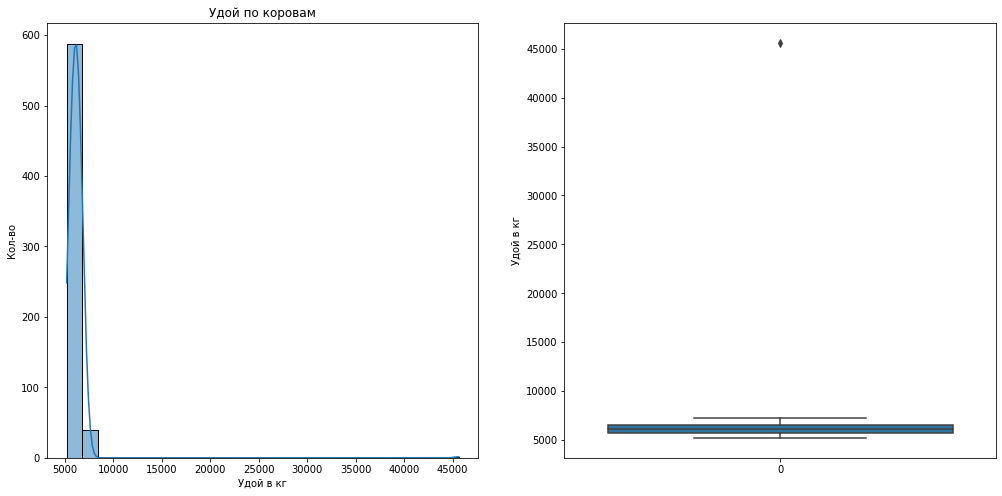

In [15]:
display(ferma_main['удой'].describe())
build_hist_box_plot(ferma_main['удой'], 'Удой по коровам', 'Удой в кг', 'Кол-во');

*Избавимся от одного аномального значения.*

In [16]:
ferma_main = ferma_main.drop(ferma_main[ferma_main['удой'] == 45616].index)

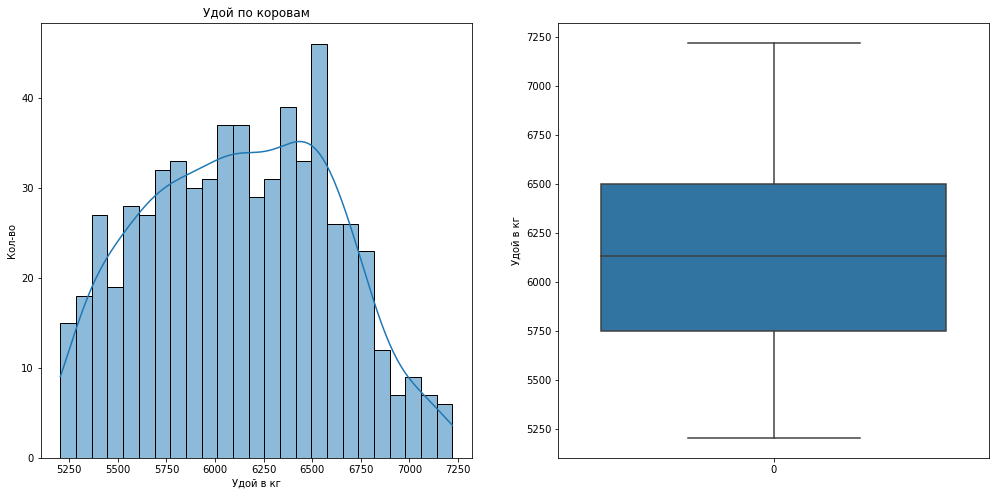

In [17]:
build_hist_box_plot(ferma_main['удой'], 'Удой по коровам', 'Удой в кг', 'Кол-во')

**Показатель питательности корма коровы**

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64

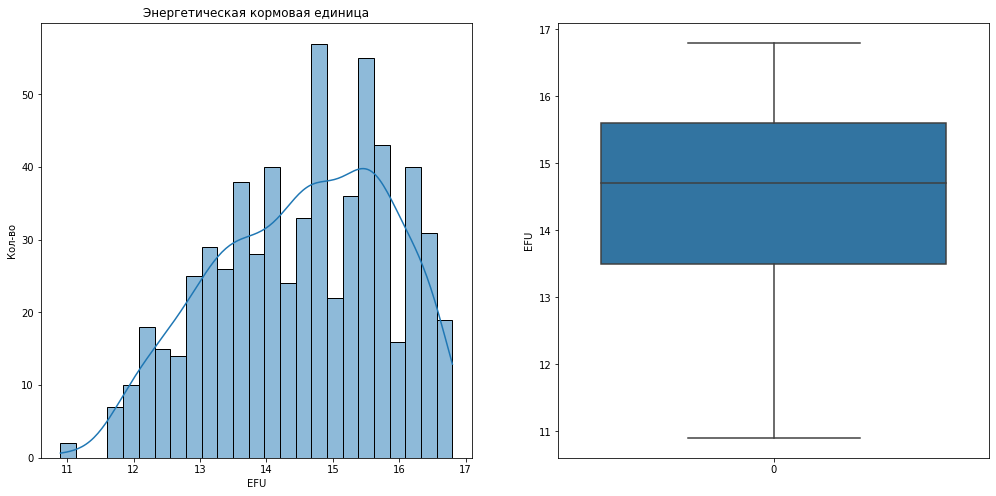

In [18]:
display(ferma_main['эке'].describe())
build_hist_box_plot(ferma_main['эке'], 'Энергетическая кормовая единица', 'EFU', 'Кол-во');

**Содержание сырого протеина в корме**

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: сырой_протеин, dtype: float64

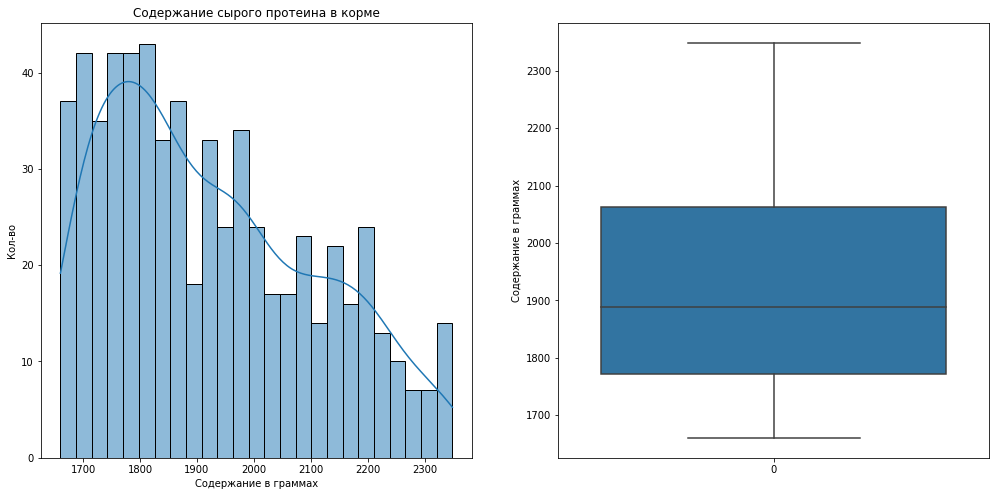

In [19]:
display(ferma_main['сырой_протеин'].describe())
build_hist_box_plot(ferma_main['сырой_протеин'], 'Содержание сырого протеина в корме', 'Содержание в граммах', 'Кол-во');

**Отношение сахара к протеину в корме**

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

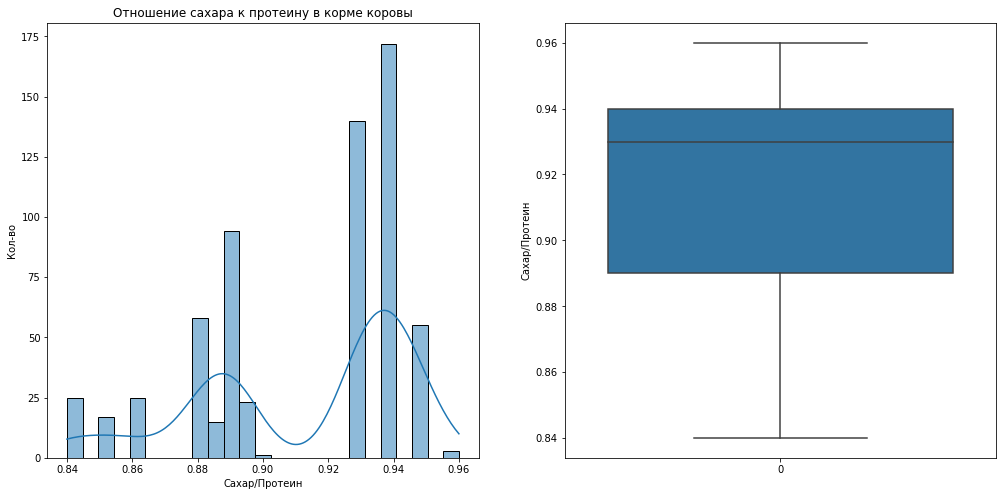

In [20]:
display(ferma_main['спо'].describe())
build_hist_box_plot(ferma_main['спо'], 'Отношение сахара к протеину в корме коровы', 'Сахар/Протеин', 'Кол-во');

**Породы коров**

вис бик айдиал     372
рефлешнсоверинг    256
Name: порода, dtype: int64

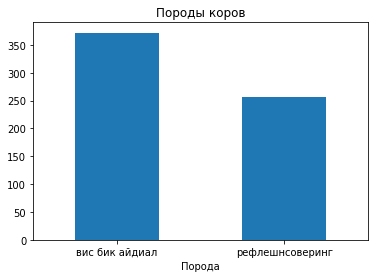

In [21]:
build_barh(ferma_main, 'порода', 'Породы коров', 'Порода')

**Типы пастбища**

холмистое    350
равнинное    253
равнинные     25
Name: тип_пастбища, dtype: int64

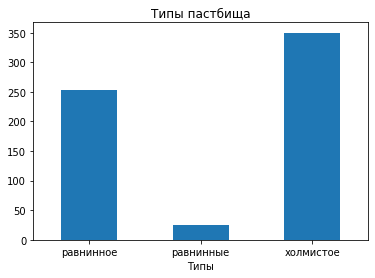

In [22]:
build_barh(ferma_main, 'тип_пастбища', 'Типы пастбища', 'Типы')


*Как видно, у нас имеется два различных способа написания одного и того же типа пастбища.*

In [23]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].apply(lambda x: 'равнинное' if x == 'равнинные' else x)

холмистое    350
равнинное    278
Name: тип_пастбища, dtype: int64

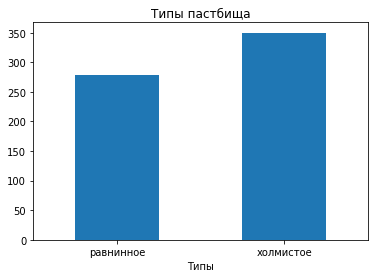

In [24]:
build_barh(ferma_main, 'тип_пастбища', 'Типы пастбища', 'Типы')

**Порода папы быка**

соверин    311
айдиал     240
айдиалл     77
Name: порода_папы_быка, dtype: int64

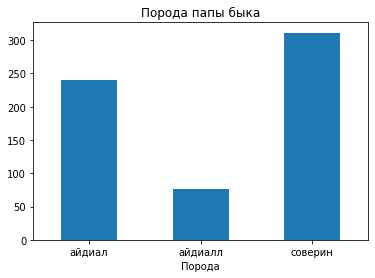

In [25]:
build_barh(ferma_main, 'порода_папы_быка', 'Порода папы быка', 'Порода')

*Как видно, у нас имеется два различных способа написания одной и той же породы.*

In [26]:
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].apply(lambda x: 'айдиал' if 'айди' in x else x)

айдиал     317
соверин    311
Name: порода_папы_быка, dtype: int64

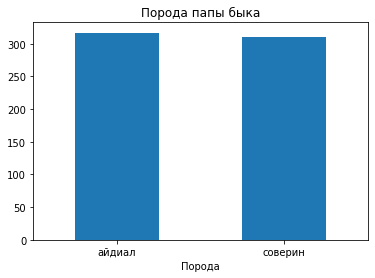

In [27]:
build_barh(ferma_main, 'порода_папы_быка', 'Порода папы быка', 'Порода')

**Содержание жиров в молоке**

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64

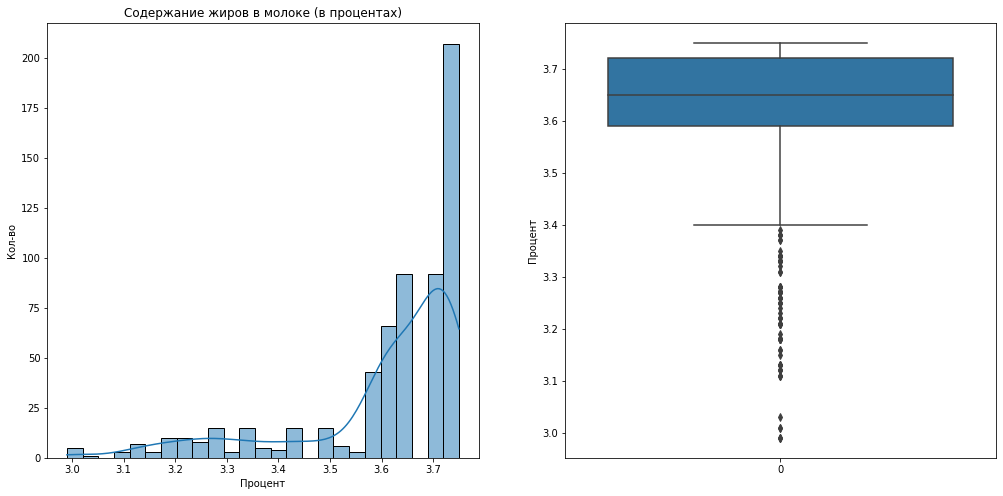

In [28]:
display(ferma_main['жирность'].describe())
build_hist_box_plot(ferma_main['жирность'], 'Содержание жиров в молоке (в процентах)', 'Процент', 'Кол-во');

**Содержание белков в молоке**

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64

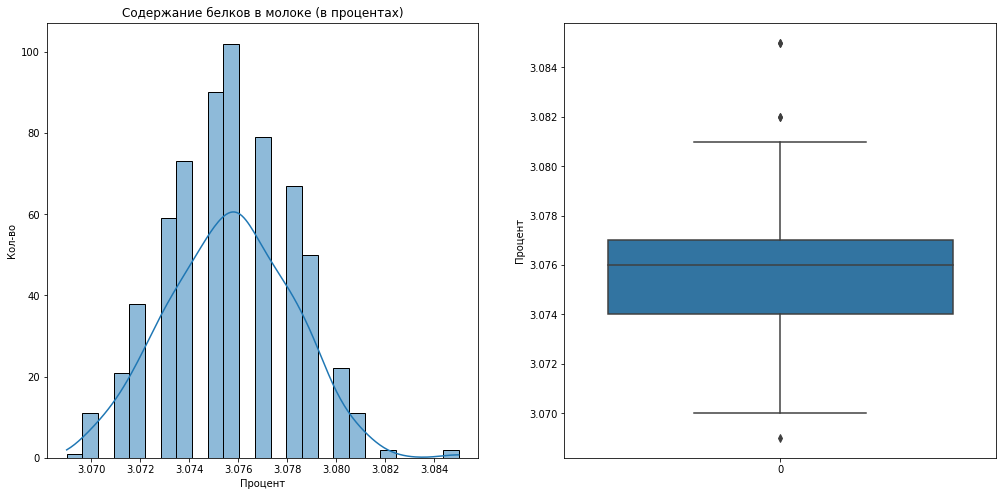

In [29]:
display(ferma_main['белок'].describe())
build_hist_box_plot(ferma_main['белок'], 'Содержание белков в молоке (в процентах)', 'Процент', 'Кол-во');

**Оценка вкуса молока**

вкусно       370
не вкусно    258
Name: вкус_молока, dtype: int64

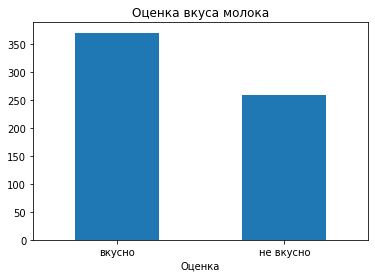

In [30]:
build_barh(ferma_main, 'вкус_молока', 'Оценка вкуса молока', 'Оценка')

**Возраст коровы**

более_2_лет    518
менее_2_лет    110
Name: возраст, dtype: int64

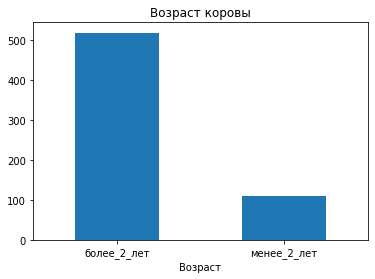

In [31]:
build_barh(ferma_main, 'возраст', 'Возраст коровы', 'Возраст')

**Имя папы быка**

барин       240
буйный      215
соловчик    110
геркулес     64
Name: имя_папы, dtype: int64

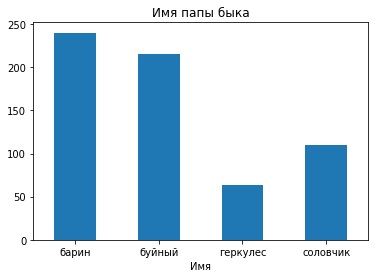

In [32]:
build_barh(ferma_dad, 'имя_папы', 'Имя папы быка', 'Имя')

### Cтатистический анализ данных о коровах «ЭкоФермы»

**Породы коров**

рефлешнсоверинг    8
вис бик айдиал     8
Name: порода, dtype: int64

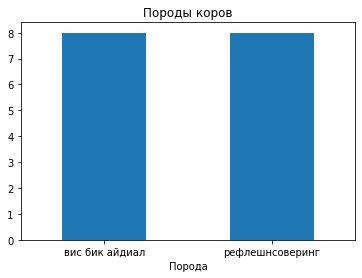

In [33]:
build_barh(cow_buy, 'порода', 'Породы коров', 'Порода')

**Тип пастбища**

холмистое    8
равнинное    8
Name: тип_пастбища, dtype: int64

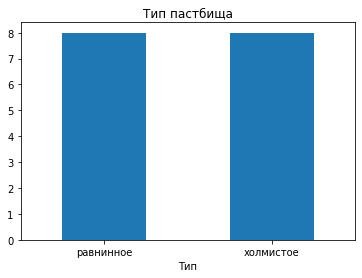

In [34]:
build_barh(cow_buy, 'тип_пастбища', 'Тип пастбища', 'Тип')

**Порода папы быка**

соверин    10
айдиал      6
Name: порода_папы_быка, dtype: int64

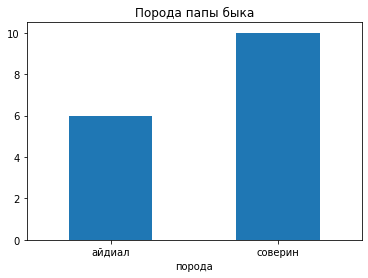

In [35]:
build_barh(cow_buy, 'порода_папы_быка', 'Порода папы быка', 'порода')

**Содержание жиров в молоке**

count    16.000000
mean      3.571875
std       0.141620
min       3.340000
25%       3.415000
50%       3.585000
75%       3.692500
max       3.770000
Name: текущая_жирность, dtype: float64

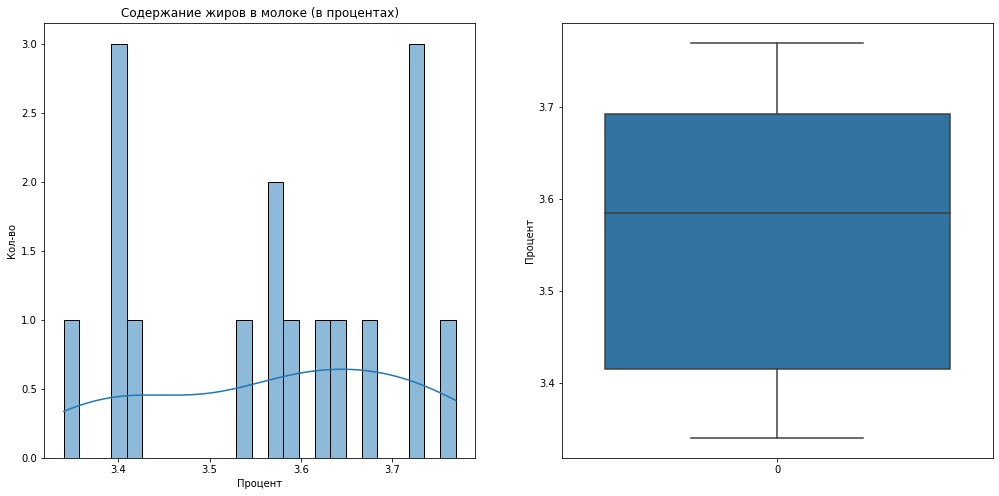

In [36]:
display(cow_buy['текущая_жирность'].describe())
build_hist_box_plot(cow_buy['текущая_жирность'], 'Содержание жиров в молоке (в процентах)', 'Процент', 'Кол-во');

**Содержание белков в молоке**

count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: текущий_уровень_белок, dtype: float64

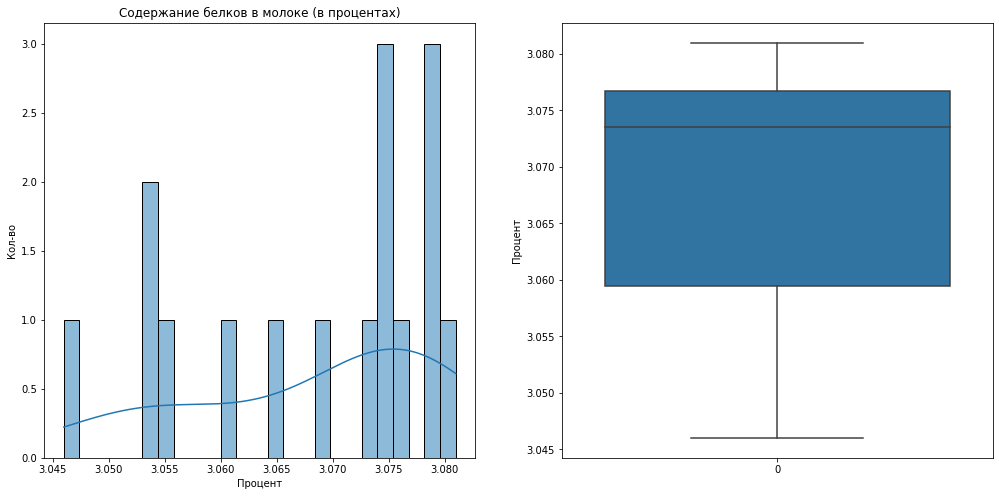

In [37]:
display(cow_buy['текущий_уровень_белок'].describe())
build_hist_box_plot(cow_buy['текущий_уровень_белок'], 'Содержание белков в молоке (в процентах)', 'Процент', 'Кол-во');

**Возраст коров**

более_2_лет    11
менее_2_лет     5
Name: возраст, dtype: int64

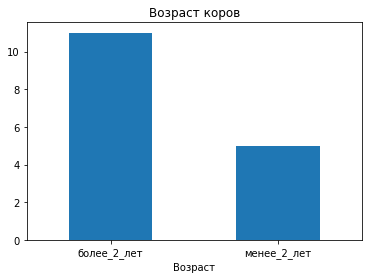

In [38]:
build_barh(cow_buy, 'возраст', 'Возраст коров', 'Возраст')

**Выводы:**

**Анализ данных о стаде фермера на текущий момент**

- Удой по коровам: уровень удоя изменяется в пределах от 5204 до 7222 кг, с медианным значением в 6132 кг. Однако также был обнаружен выброс, составляющий около 45616 кг, от которого мы избавились.
- Показатель питательности корма: содержание питательных веществ в корме варьируется в диапазоне от 10 до 16 единиц, при медианном значении около 14.7. Наблюдается умеренное правостороннее скошенное распределение.
- Содержание сырого протеина в корме: значения распределились между 1660 и 2349 граммами, с медианным значением равным 1888 граммам. Наблюдается левостороннее скошенное распределение.
- Отношение сахара к протеину в корме: мы наблюдаем бимодальное распределение, значения которого находятся в диапазоне от 0.84 до 0.96. Первый пик располагается около 0.89, а второй в районе 0.93, при этом медианное значение составляет 0.93.
- Породы коров: лидирующей породой является Вис Бик Айдиал.
- Типы пастбища: При анализе типов была обнаружена ошибка, и один и тот же тип записывался по-разному. Среди типов преобладает "холмистый".
- Порода папы быка: Также была выявлена ошибка, где одна и та же порода записывалась по-разному. В данном случае у нас нет четкого лидера, однако наблюдается небольшое преобладание породы Айдиал.
- Содержание жиров в молоке: содержание жиров варьируется в пределах от 2.9% до 3.75% с медианным значением 3.65%. При анализе boxplot были выявлены выбросы, однако из-за их плотного распределения мы не планируем их исключать. Распределение скошенно и обладает отрицательной асимметрией.
- Содержание белков в молоке: содержание белков в молоке имеет нормальное распределение со значениями, варьирующимися в пределах от 3.069% до 3.085%, и медианой, равной 3.076%. При анализе boxplot также обнаружены выбросы, но они не существенные, и поэтому мы не планируем их удалять.
- Оценка вкуса молока: при оценке вкуса, в большинстве случаев преобладает вкусное молоко.
- Возраст коровы: коровы старше 2 лет преобладают с заметным перевесом.
- Имя папы быка: Чаще всего в роли родителей выступают быки с именами Барин и Буйный.

**Анализ данных о коровах «ЭкоФермы»**

- Породы коров: у нас наблюдается равное количество представителей пород Вис Бик Айдиал и РефлешнСоверинг.
- Тип пастбища: также мы имеем равное количество представителей разных типов пастбищ.
- Порода папы быка: порода Соверин преобладает.
- Содержание жиров в молоке: значения содержания жиров распределились между 3.34% и 3.77%, с медианой на уровне 3.58%. Обнаружены два выраженных всплеска в значениях, один около 3.4%, а другой в районе 3.75%.
- Содержание белков в молоке: значения содержания белков распределились между 3.04% и 3.08%, с медианой на уровне 3.07%. 
- Возраст коров: Тут так же преобладают корове старше двух лет.

*Вероятно, ошибки в данных вызваны человеческим фактором. Мы провели коррекцию и удаление всех обнаруженных ошибок и аномалий в данных.*

## Корреляционный анализ

###  Взаимосвязь между всеми признаками

interval columns not set, guessing: ['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']


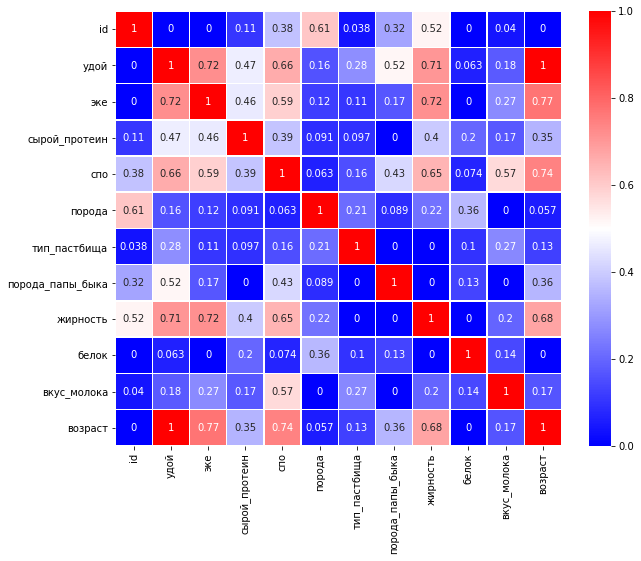

In [39]:
#Построим тепловую карту для матрицы корреляции phik
plt.figure(figsize=(10, 8))
sns.heatmap(ferma_main.phik_matrix(), annot=True, cmap='bwr', linewidths=0.5);

- Высока корреляция с целевым признаком: возраст - 1, эке - 0.72, жирность - 0.71 
- Заметная корреляция с целевым признаком: спо - 0.66, порода_папы_быка - 0.52, сырой_протеин - 0.47

**Мультиколлинеарность не наблюдается**

###  Взаимосвязь между удоем и всеми колличественными признаками

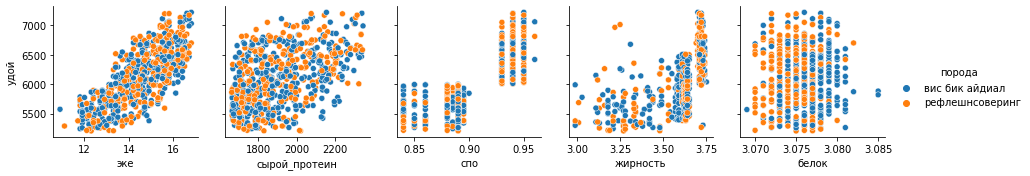

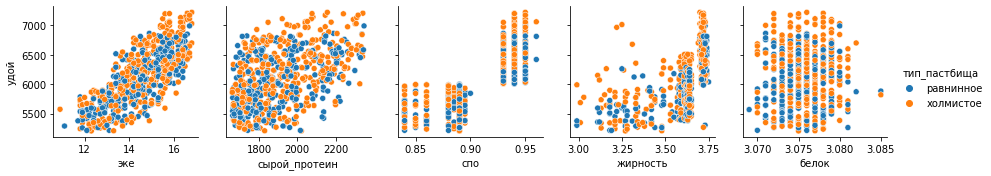

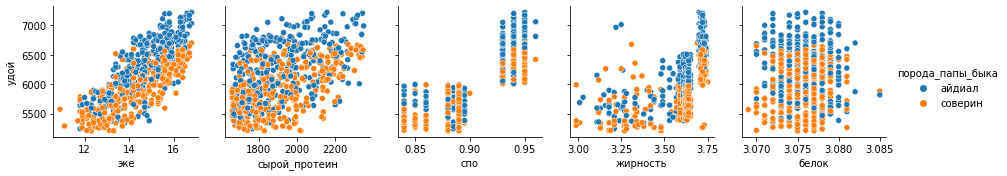

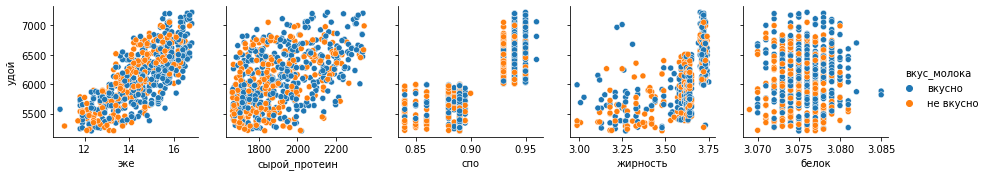

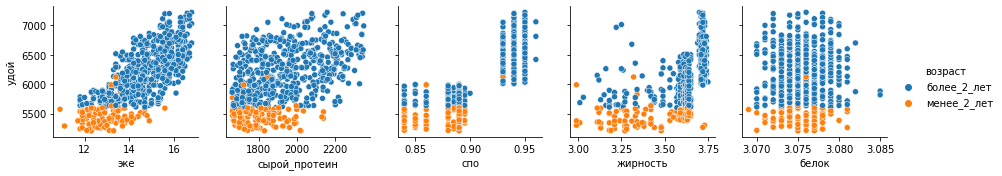

In [40]:
cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']
factor = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок' ]
targ = 'удой'

for category in cat:
        g = sns.PairGrid(ferma_main, hue = category, x_vars=factor, y_vars=targ)
        g.map(sns.scatterplot)
        g.add_legend()
plt.show()

- Взаимосвязь между удоем и показателем питательности корма вероятнее всего нелинейна. 
- Взаимосвязь между  удоем и содержанием сырого протеина в корме является **слабой положительной линейной**. 
- Взаимосвязь между удоем и отношением сахара к протеину в корме является нелинейным.
- Взаимосвязь между удоем и жирностью молока нелинейна.
- Взаимосвязь между удоем и содержанием белков в молоке не наблюдается.

**Выводы:**
- Наибольшая корреляция целевого признака наблюдается с возрастом, эке и жирностью
- Мультиколлинеарность не наблюдается
- Сырой протеин имеет слабую линейную взаимосвязь с целевым признаком, остальные же признаки связаны нелинейно. 
- Так же было выявлено что удой больше всего зависит от породы и возраста коровы.

## Обучение модели линейной регрессии

### Первая модель линейной регрессии

Для первой модели мы возьмем следующие признаки:
- ЭКЕ  
- Сырой протеин
- СПО
- Возраст
- Порода
- Тип пастбища
- Порода папы быка

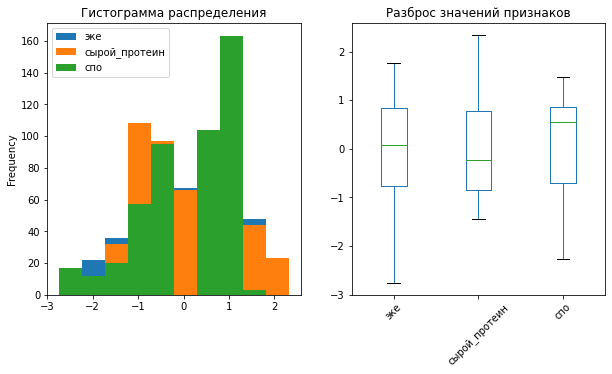

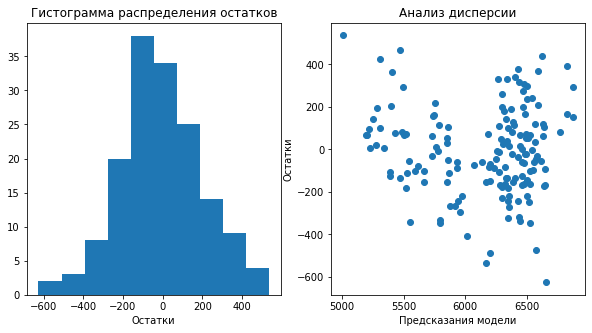

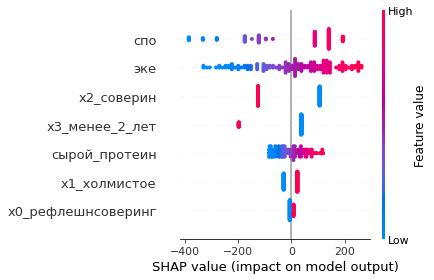



                    Коэффициенты
x0_рефлешнсоверинг     13.662467
x1_холмистое           51.212944
x2_соверин           -231.902082
x3_менее_2_лет       -234.920007
эке                   155.211731
сырой_протеин          53.993058
спо                   168.180088


MSE LinearRegression = 42848.42461806656
RMSE LinearRegression = 206.9986101839009
MAE LinearRegression = 163.32816876077527
R2 LinearRegression = 0.8108968108993193
Модель в среднем ошиается на 163.33 литров молока
Доверительный интервал (95%): (6083.216338080876, 6222.356139926413)


In [41]:
first_scaler, first_encoder, first_model = crete_linear_model(['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст'],
                                                              ['эке', 'сырой_протеин', 'спо'])

**По результатам анализа остатков можно утверждать, что они распределены нормально. Однако, при более подробном анализе дисперсии, обнаруживается их непостоянство. Скорее всего, это обусловлено ограниченным объемом данных для коров с высокими удоями.**


### Вторая модель линейной регрессии

Для втоой модели мы возьмем следующие признаки:
- ЭКЕ  
- ЭКЕ в квадрате
- Сырой протеин
- СПО
- СПО категориальный
- Возраст
- Порода
- Тип пастбища
- Порода папы быка

In [42]:
ferma_main['спо_категориальный'] = ferma_main['спо'].apply(lambda x: 0 if x < 0.92 else 1) 

In [43]:
ferma_main['эке_квадрат'] = ferma_main['эке']**2

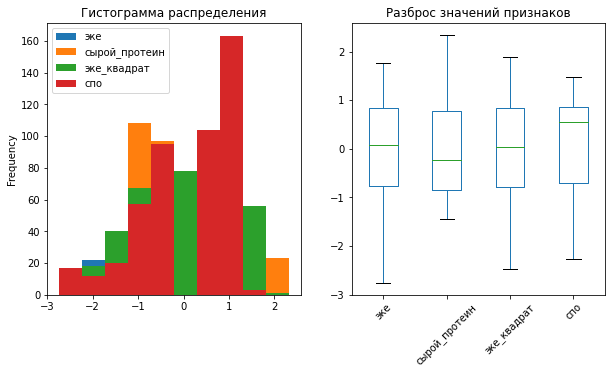

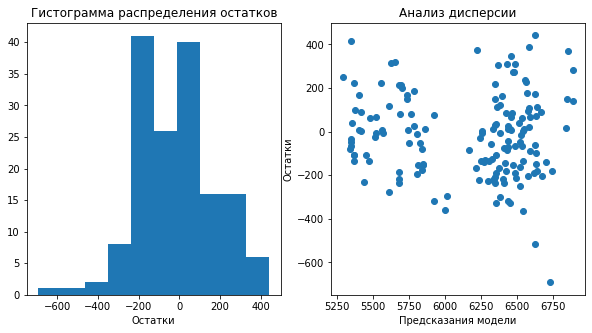

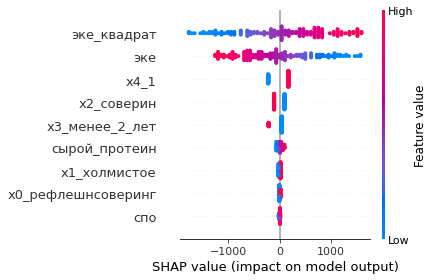



                    Коэффициенты
x0_рефлешнсоверинг     19.573045
x1_холмистое           35.137203
x2_соверин           -202.352283
x3_менее_2_лет       -254.133834
x4_1                  391.991937
эке                  -738.340324
сырой_протеин          44.015766
эке_квадрат           878.943436
спо                     7.598015


MSE LinearRegression = 36707.77556301321
RMSE LinearRegression = 191.59273358614936
MAE LinearRegression = 152.44312411808946
R2 LinearRegression = 0.8379973713005308
Модель в среднем ошиается на 152.44 литров молока
Доверительный интервал (95%): (6093.705209808226, 6234.63765390934)


In [44]:
second_scaler, second_encoder, second_model = crete_linear_model(['порода', 'тип_пастбища', 'порода_папы_быка',
                                                                  'возраст','спо_категориальный'],
                                                                 ['эке', 'сырой_протеин', 'эке_квадрат',  'спо'])

**Нам удалось улучшить работу модели и поднять значение R2 почти на 3%. Но у этой модели наблюдается та же проблема непостоянства остатков.**

### Третья модель линейной регрессии

Для третей модели мы возьмем следующие признаки:
- ЭКЕ  
- ЭКЕ в квадрате
- Сырой протеин
- СПО
- СПО категориальный
- Возраст
- Порода
- Тип пастбища
- Порода папы быка
- Имя папы

In [45]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how='inner')

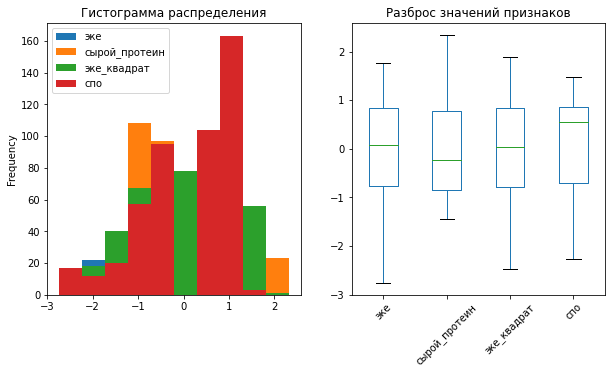

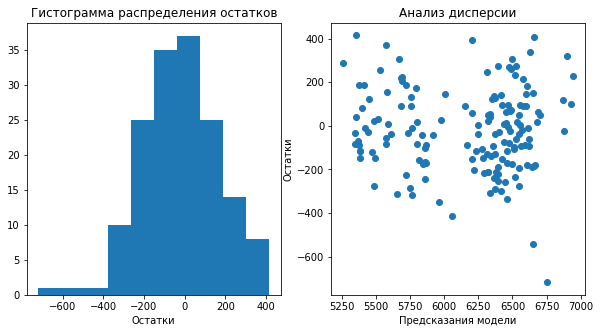

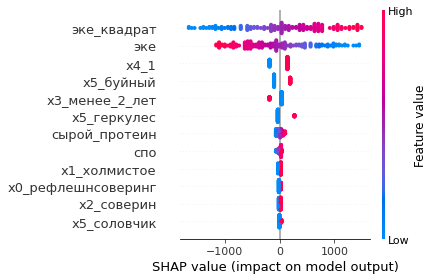



                    Коэффициенты
x0_рефлешнсоверинг     36.445721
x1_холмистое           53.614750
x2_соверин             32.400671
x3_менее_2_лет       -223.009022
x4_1                  326.623598
x5_буйный             294.574443
x5_геркулес           302.269508
x5_соловчик            33.912105
эке                  -681.841014
сырой_протеин          45.978422
эке_квадрат           826.001393
спо                    29.734392


MSE LinearRegression = 35946.56373975907
RMSE LinearRegression = 189.59579040621938
MAE LinearRegression = 150.64001738877238
R2 LinearRegression = 0.8413568316457265
Модель в среднем ошиается на 150.64 литров молока
Доверительный интервал (95%): (6095.372547428943, 6235.771043137488)


In [46]:
third_scaler,third_encoder, third_model = crete_linear_model(['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст',
                                                                'спо_категориальный', 'имя_папы'],
                                                               ['эке', 'сырой_протеин', 'эке_квадрат', 'спо'])

**Третья модель показывает наилучшие результаты метрик, а так же нам удалось немного уменшить непостоянство диспреси.**



### Прогноз удоя коров.

In [47]:
cow_buy = cow_buy.assign(эке=(ferma_main['эке'].mean() * 1.05), 
                         сырой_протеин=ferma_main['сырой_протеин'].mean() * 1.05, 
                         спо=ferma_main['спо'].mean() * 1.05)

cow_buy['эке_квадрат'] = cow_buy['эке']**2
cow_buy['спо_категориальный'] = cow_buy['спо'].apply(lambda x: 0 if x < 0.92 else 1) 

X = cow_buy[['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категориальный', 'имя_папы','эке',
             'сырой_протеин', 'эке_квадрат', 'спо']]

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категориальный', 'имя_папы'] 
num_col_names = ['эке', 'сырой_протеин', 'эке_квадрат', 'спо']

X_ohe = third_encoder.transform(X[cat_col_names])
encoder_col_names = third_encoder.get_feature_names()
X_scaled = third_scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)


X = pd.concat([X_ohe, X_scaled], axis=1)

milk_yield_pred = third_model.predict(X)

mean_estimate = np.mean(milk_yield_pred)
std_error = np.std(milk_yield_pred, ddof=1) / np.sqrt(len(milk_yield_pred))
z_value = st.norm.ppf(0.975)
confidence_interval = (mean_estimate - z_value * std_error, mean_estimate + z_value * std_error)
print("Доверительный интервал (95%):", confidence_interval)

Доверительный интервал (95%): (6383.337137589504, 6532.293635729846)


**Вывод: после проведения тестирования моделей, мы выбрали третью модель, с показателем R2 равным 0.84. В данной модели мы  дополнительно использовала предиктор `имя_папы` для предсказаний. Затем мы выполнили прогноз на основе данных из датафрейма `cow_buy`, а результаты сохранили в переменную `milk_yield_pred`**

## Обучение модели логистической регрессии

###  Обучение модели логистической регрессии.

In [48]:
ferma_main['вкус_молока'] = ferma_main['вкус_молока'].apply(lambda x: 1 if x == 'вкусно'  else 0) 

accuracy:  0.682
recall:  0.672
precision:  0.891


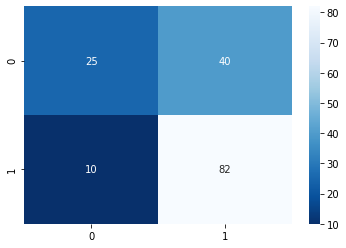

In [49]:
X = ferma_main.drop(columns=['id','вкус_молока'], axis=1)
y = ferma_main['вкус_молока']

RANDOM_STATE = 43

X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE,
stratify=y)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категориальный', 'имя_папы']
num_col_names = ['эке', 'сырой_протеин', 'эке_квадрат', 'спо', 'жирность', 'белок']

encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression(random_state=RANDOM_STATE)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


metrics_logistic_regression(y_pred, y_test)

Учитывая, что важным для нас является точное предсказание положительного класса (вкусного молока), особое внимание следует уделить метрике precision.

In [50]:
#подбор порогового значения
y_proba = clf.predict_proba(X_test)[:, 1] 
data = pd.DataFrame(zip(y_test, y_proba),
columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False) 


def mist_counter(y_valid,y_pred_):
    if y_valid == 0 and y_pred_ == 1:
        return 1
    else:
        return 0
    
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 22,endpoint=False)]
values = []
columns = []
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)
    data['check'] = data.apply(lambda x : mist_counter(x.y_valid,x.y_pred_), 1)
    if data['check'].sum() == 0:
        new_threshold = i
        break
        
print(f'Пороговое значение для максимизации precision - {new_threshold}')

Пороговое значение для максимизации precision - 0.84


accuracy:  0.268
recall:  0.057
precision:  1.0


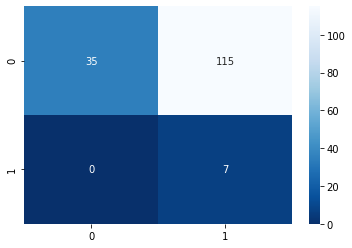

In [51]:
y_pred_new_threshold = (y_proba >= new_threshold).astype(int)
metrics_logistic_regression(y_pred, y_pred_new_threshold)

Установив порог классификации на уровень 0.84, нам удалось минимизировали ошибки False Negative

###   Прогноз вкуса молока.

In [52]:
cow_buy = cow_buy.rename(columns={"текущая_жирность": "жирность", "текущий_уровень_белок": "белок"})
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_категориальный
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
8,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
9,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1


In [53]:
X = cow_buy

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категориальный', 'имя_папы']
num_col_names = ['эке', 'сырой_протеин', 'эке_квадрат', 'спо', 'жирность', 'белок']


X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)


y_pred = clf.predict_proba(X)[:, 1]

In [54]:
cow_buy['прогнозируемый_вкус_молока'] = pd.Series(y_pred).apply(lambda x: 'Вкусное' if x >= 0.75 else 'Не вкусное')
cow_buy['прогнозируемый_удой'] = milk_yield_pred
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_категориальный,прогнозируемый_вкус_молока,прогнозируемый_удой
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6590.534756
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6338.616590
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Не вкусное,6303.496890
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6619.285412
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Не вкусное,6565.670662
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Не вкусное,6382.757376
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6561.625612
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6396.276390
8,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Не вкусное,6354.578024
9,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Не вкусное,6605.766398


**Вывод: при обучении модели логистической регрессии мы уделили особое внимание поиску подходящего порогового значения для классификации. После проведения соответствующих вычислений и анализа, мы установили оптимальное пороговое значение равным 0.84.**

## Итоговые выводы

In [55]:
recommendations = cow_buy.query('прогнозируемый_удой >= 6000 and прогнозируемый_вкус_молока == "Вкусное"')
recommendations

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_категориальный,прогнозируемый_вкус_молока,прогнозируемый_удой
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6590.534756
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6338.616590
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6619.285412
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6561.625612
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6396.276390
11,вис бик айдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6097.656897
12,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.065,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6619.285412
13,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6354.578024
15,вис бик айдиал,равнинное,соверин,буйный,3.34,3.069,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1,Вкусное,6561.625612


### Этапы: 

- **Загрузка данных** на данном этапе мы изучили основную информацию о датафреймах, провели стандартизацию названий колонок. Пропуски в данных не обнаружены.


- **Предобработка данных** на этапе предобработки данных, мы провели очистку данных от дубликатов.


- **Анализ данных о стаде фермера на текущий момент**

    Удой по коровам: уровень удоя изменяется в пределах от 5204 до 7222 кг, с медианным значением в 6132 кг. Однако также был обнаружен выброс, составляющий около 45616 кг, от которого мы избавились.
    
    Показатель питательности корма: содержание питательных веществ в корме варьируется в диапазоне от 10 до 16 единиц, при медианном значении около 14.7. Наблюдается умеренное правостороннее скошенное распределение.
    
    Содержание сырого протеина в корме: значения распределились между 1660 и 2349 граммами, с медианным значением равным 1888 граммам. Наблюдается левостороннее скошенное распределение.
    
    Отношение сахара к протеину в корме: мы наблюдаем бимодальное распределение, значения которого находятся в диапазоне от 0.84 до 0.96. Первый пик располагается около 0.89, а второй в районе 0.93, при этом медианное значение составляет 0.93.
    Породы коров: лидирующей породой является Вис Бик Айдиал.
    
    Типы пастбища: При анализе типов была обнаружена ошибка, и один и тот же тип записывался по-разному. Среди типов преобладает "холмистый".
    
    Порода папы быка: Также была выявлена ошибка, где одна и та же порода записывалась по-разному. В данном случае у нас нет четкого лидера, однако наблюдается небольшое преобладание породы Айдиал.
    
    Содержание жиров в молоке: содержание жиров варьируется в пределах от 2.9% до 3.75% с медианным значением 3.65%. При анализе boxplot были выявлены выбросы, однако из-за их плотного распределения мы не планируем их исключать. Распределение скошенно и обладает отрицательной асимметрией.
    
    Содержание белков в молоке: содержание белков в молоке имеет нормальное распределение со значениями, варьирующимися в пределах от 3.069% до 3.085%, и медианой, равной 3.076%. При анализе boxplot также обнаружены выбросы, но они не существенные, и поэтому мы не планируем их удалять.
    
    Оценка вкуса молока: при оценке вкуса, в большинстве случаев преобладает вкусное молоко.
    
    Возраст коровы: коровы старше 2 лет преобладают с заметным перевесом.
    
    Имя папы быка: Чаще всего в роли родителей выступают быки с именами Барин и Буйный.
    

- **Анализ данных о коровах «ЭкоФермы»**

    Породы коров: у нас наблюдается равное количество представителей пород Вис Бик Айдиал и РефлешнСоверинг.
    
    Тип пастбища: также мы имеем равное количество представителей разных типов пастбищ.
    
    Порода папы быка: порода Соверин преобладает.
    
    Содержание жиров в молоке: значения содержания жиров распределились между 3.34% и 3.77%, с медианой на уровне 3.58%. 
    
    Обнаружены два выраженных всплеска в значениях, один около 3.4%, а другой в районе 3.75%.
    
    Содержание белков в молоке: значения содержания белков распределились между 3.04% и 3.08%, с медианой на уровне 3.07%.
    
    Возраст коров: Тут так же преобладают корове старше двух лет.
    
    
- **Корреляционный анализ**

    - Наибольшая корреляция целевого признака наблюдается с возрастом, эке и жирностью
    
    - Мультиколлинеарность не наблюдается
    
    - `сырой_протеин`(Содержание сырого протеина в корме) имеет линейную взаимосвязь с целевым признаком, остальные же признаки связаны нелинейно.
    
    
- **Обучение модели линейной регрессии**

    После проведения тестирования моделей, мы выбрали третью модель, с показателем R2 равным 0.84. В данной модели мы  дополнительно использовала предикторы `ЭКЕ`, `ЭКЕ в квадрате`, `Сырой протеин`, `СПО`, `СПО категориальный`, `Возраст`, `Порода`, `Тип пастбища`, `Порода папы быка`, `Имя папы` для предсказаний. Затем мы выполнили прогноз на основе данных из датафрейма `cow_buy`, а предсказания сохранили в переменную `milk_yield_pred`.
        
- **Обучение модели логистической регрессии**

    При обучении модели логистической регрессии мы уделили особое внимание поиску подходящего порогового значения для классификации. После проведения соответствующих вычислений и анализа, мы установили оптимальное пороговое значение равным 0.84.
    
    
### Вывод: 

- С минимальным риском для себя фермер может приобрести девять коров, информация о которых предоставлена в датафрейме "recommendations".


-  Как рекомендацию, следует отметить, что в сборе данных о коровах практически не бывает лишних информационных деталей. Например, данные о точном возрасте коров могут быть весьма полезны, так как возраст сильно влияет на их удой. Фермеру следует стремиться собирать как можно больше данных, чтобы принимать более обоснованные решения.


- Мы использовали следующие способы улучшения качества регрессионой модели:
    - Бинаризацию(преобразование количественного признака в категориальный)
    - Полиномиальный признак(возводит исходный признак в заданную степень для учета нелинейных зависимостей в модели)


- Для улучшения результатов регрессионной модели можно провести более детальную настройку параметров модели, а также расширить объем данных, на которых модель будет обучаться.


- При анализе рисков или экономических расчетов важными следующие метрики :

    - Accuracy: Оценивает долю правильно классифицированных наблюдений.

    - Recall: Показывает способность модели выявлять положительные случаи (истинные положительные). 

    - Precision: Оценивает способность модели избегать ложных срабатываний.